Vasmos a cargar el dataset de AirBnB descargado de [aquí](https://public.opendatasoft.com/explore/dataset/airbnb-listings/export/?disjunctive.host_verifications&disjunctive.amenities&disjunctive.features&q=Madrid&dataChart=eyJxdWVyaWVzIjpbeyJjaGFydHMiOlt7InR5cGUiOiJjb2x1bW4iLCJmdW5jIjoiQ09VTlQiLCJ5QXhpcyI6Imhvc3RfbGlzdGluZ3NfY291bnQiLCJzY2llbnRpZmljRGlzcGxheSI6dHJ1ZSwiY29sb3IiOiJyYW5nZS1jdXN0b20ifV0sInhBeGlzIjoiY2l0eSIsIm1heHBvaW50cyI6IiIsInRpbWVzY2FsZSI6IiIsInNvcnQiOiIiLCJzZXJpZXNCcmVha2Rvd24iOiJyb29tX3R5cGUiLCJjb25maWciOnsiZGF0YXNldCI6ImFpcmJuYi1saXN0aW5ncyIsIm9wdGlvbnMiOnsiZGlzanVuY3RpdmUuaG9zdF92ZXJpZmljYXRpb25zIjp0cnVlLCJkaXNqdW5jdGl2ZS5hbWVuaXRpZXMiOnRydWUsImRpc2p1bmN0aXZlLmZlYXR1cmVzIjp0cnVlfX19XSwidGltZXNjYWxlIjoiIiwiZGlzcGxheUxlZ2VuZCI6dHJ1ZSwiYWxpZ25Nb250aCI6dHJ1ZX0%3D&location=16,41.38377,2.15774&basemap=jawg.streets)

![](img/descargar.png)

In [1]:
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
airbnb<-read.csv('airbnb-listings.csv',sep = ';')
options(repr.plot.height=4,repr.plot.width=6,repr.plot.res = 300)

Vamos a quedarnos con las columnas de mayor interés:

'City','Room.Type','Neighbourhood','Accommodates','Bathrooms','Bedrooms','Beds','Price','Square.Feet','Guests.Included','Extra.People','Review.Scores.Rating','Latitude', 'Longitude'

In [3]:
guardar<-c('City','Room.Type','Neighbourhood','Accommodates','Bathrooms','Bedrooms','Beds','Price','Square.Feet','Guests.Included','Extra.People','Review.Scores.Rating','Latitude', 'Longitude')

In [4]:
airbnb <- airbnb[guardar]

Nos quedarmos solo con las entradas de Madrid para Room.Type=="Entire home/apt" y cuyo barrio (Neighbourhood) no está vacio ''
Podemos eliminar las siguientes columnas que ya no son necesarias:
"Room.Type",'City'

Llama a nuevo dataframe df_madrid.

In [5]:
df_madrid<-filter(airbnb, City == 'Madrid')
df_madrid<-filter(df_madrid, Room.Type == "Entire home/apt")
df_madrid$Neighbourhood[df_madrid$Neighbourhood==''] <-NA
df_madrid <- df_madrid[!is.na(df_madrid$Neighbourhood),]
df_madrid$Square.Meters <- df_madrid$Square.Feet*0.092903

In [8]:
borrar <- c("Room.Type","City")
df_madrid <- df_madrid[ , !(names(df_madrid) %in% borrar)]

¿Que porcentaje de los apartamentos no muestran los metros cuadrados? Es decir, ¿cuantos tienen NA en Square.Meters?

In [9]:
sapply(df_madrid, function(x) sum(is.na(x)))

Neighbourhood         Accommodates            Bathrooms 
                   0                    0                   14 
            Bedrooms                 Beds                Price 
                   7                    8                    5 
         Square.Feet      Guests.Included         Extra.People 
                5254                    0                    0 
Review.Scores.Rating             Latitude            Longitude 
                 833                    0                    0 
       Square.Meters 
                5254

De todos los apartamentos que tienen un valor de metros cuadrados diferente de NA 
¿Que porcentaje de los apartamentos tienen 0 metros cuadrados?

In [10]:
prop.table(table(df_madrid$Square.Meters == 0))


    FALSE      TRUE 
0.6311239 0.3688761 

*Un 36.89% de los apartamentos sin contar los NA tiene 0 metros cuadrados.*

Reemplazar todos los 0m^2 por NA 

In [11]:
df_madrid$Square.Meters[df_madrid$Square.Meters==0] <-NA

Son muchos, vamos a intentar crear un modelo que nos prediga cuantos son los metros cuadrados en función del resto de variables para tratar de rellenar esos NA.

Antes de eso deberíamos pintar el histograma de los metros cuadrados y ver si tenemos que filtrar algún elemento más.

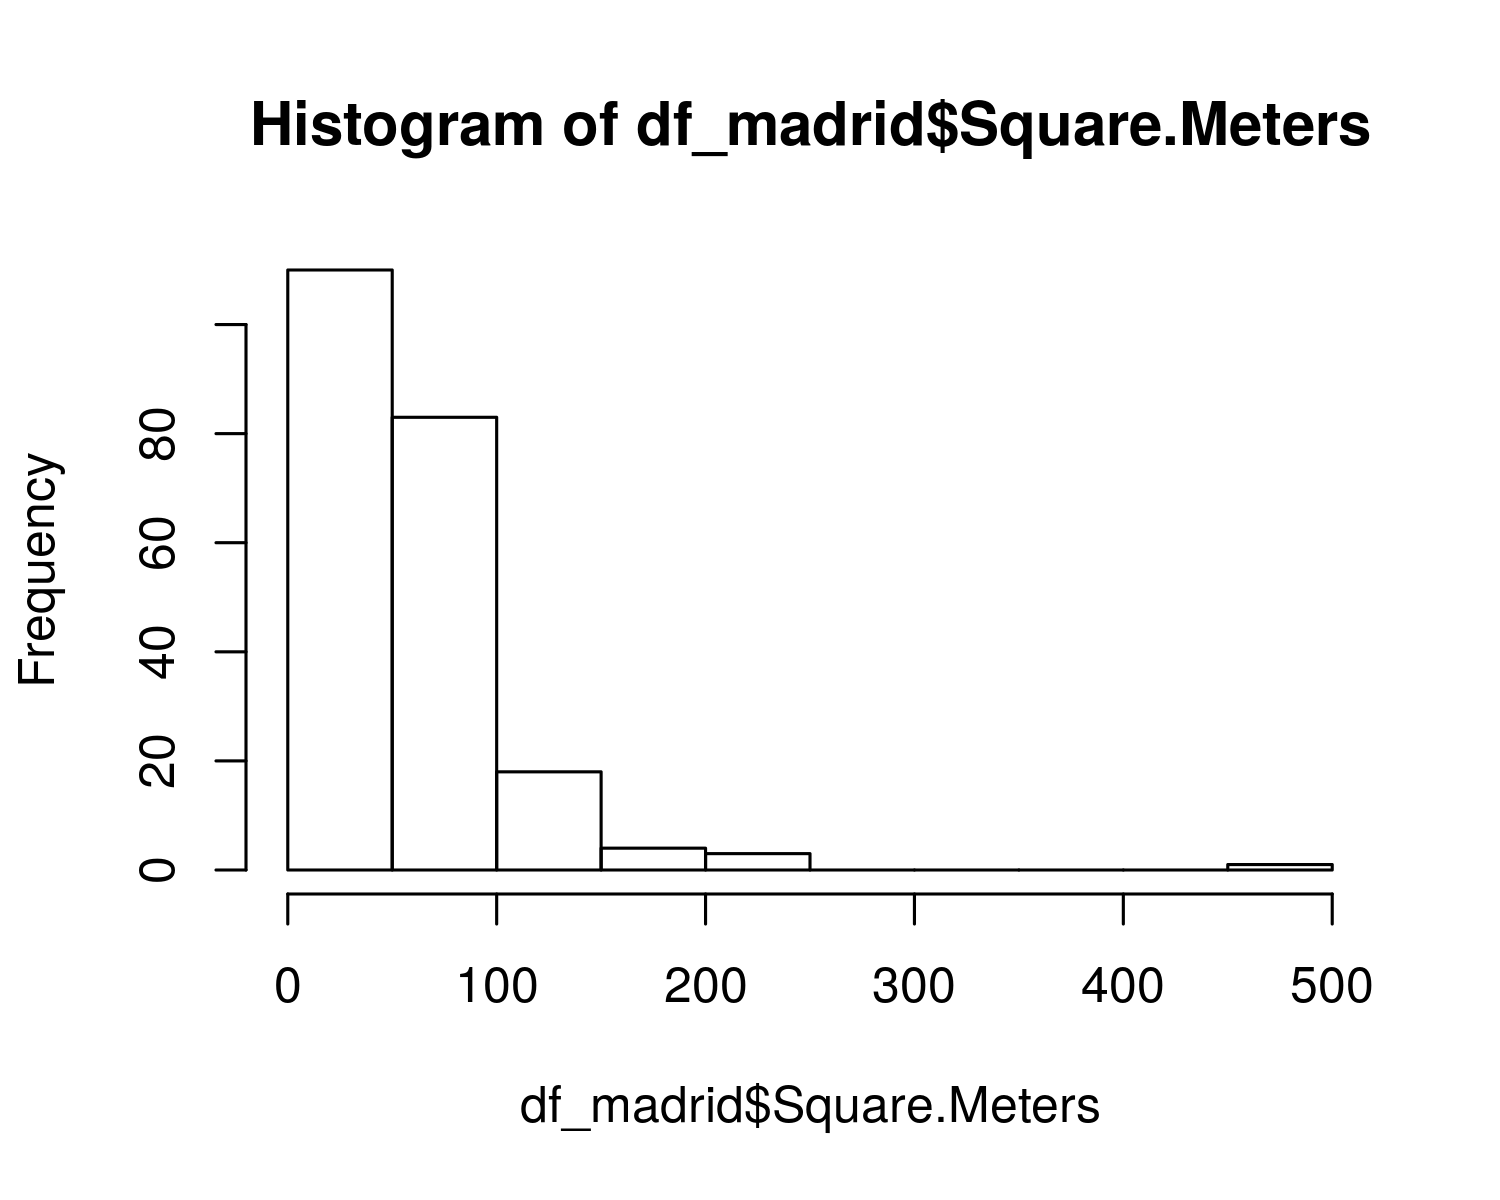

In [12]:
options(repr.plot.height=4,repr.plot.width=5) 
hist(df_madrid$Square.Meters)

Asigna el valor NA a la columna Square.Meters de los apartamentos que tengan menos de 20 m^2

In [13]:
df_madrid$Square.Meters[df_madrid$Square.Meters<20] <-NA

El barrio parece ser un indicador importante para los metros cuadrados de un apartamento.

Vamos a agrupar los barrios por metros cuadrados. Podemos usar una matriz de similaridad de Tukey tal y como hicimos en el curso de estadística:

Warning message in resm[lower.tri(resm)] <- round(tky.result$p.adj, 4):
“number of items to replace is not a multiple of replacement length”


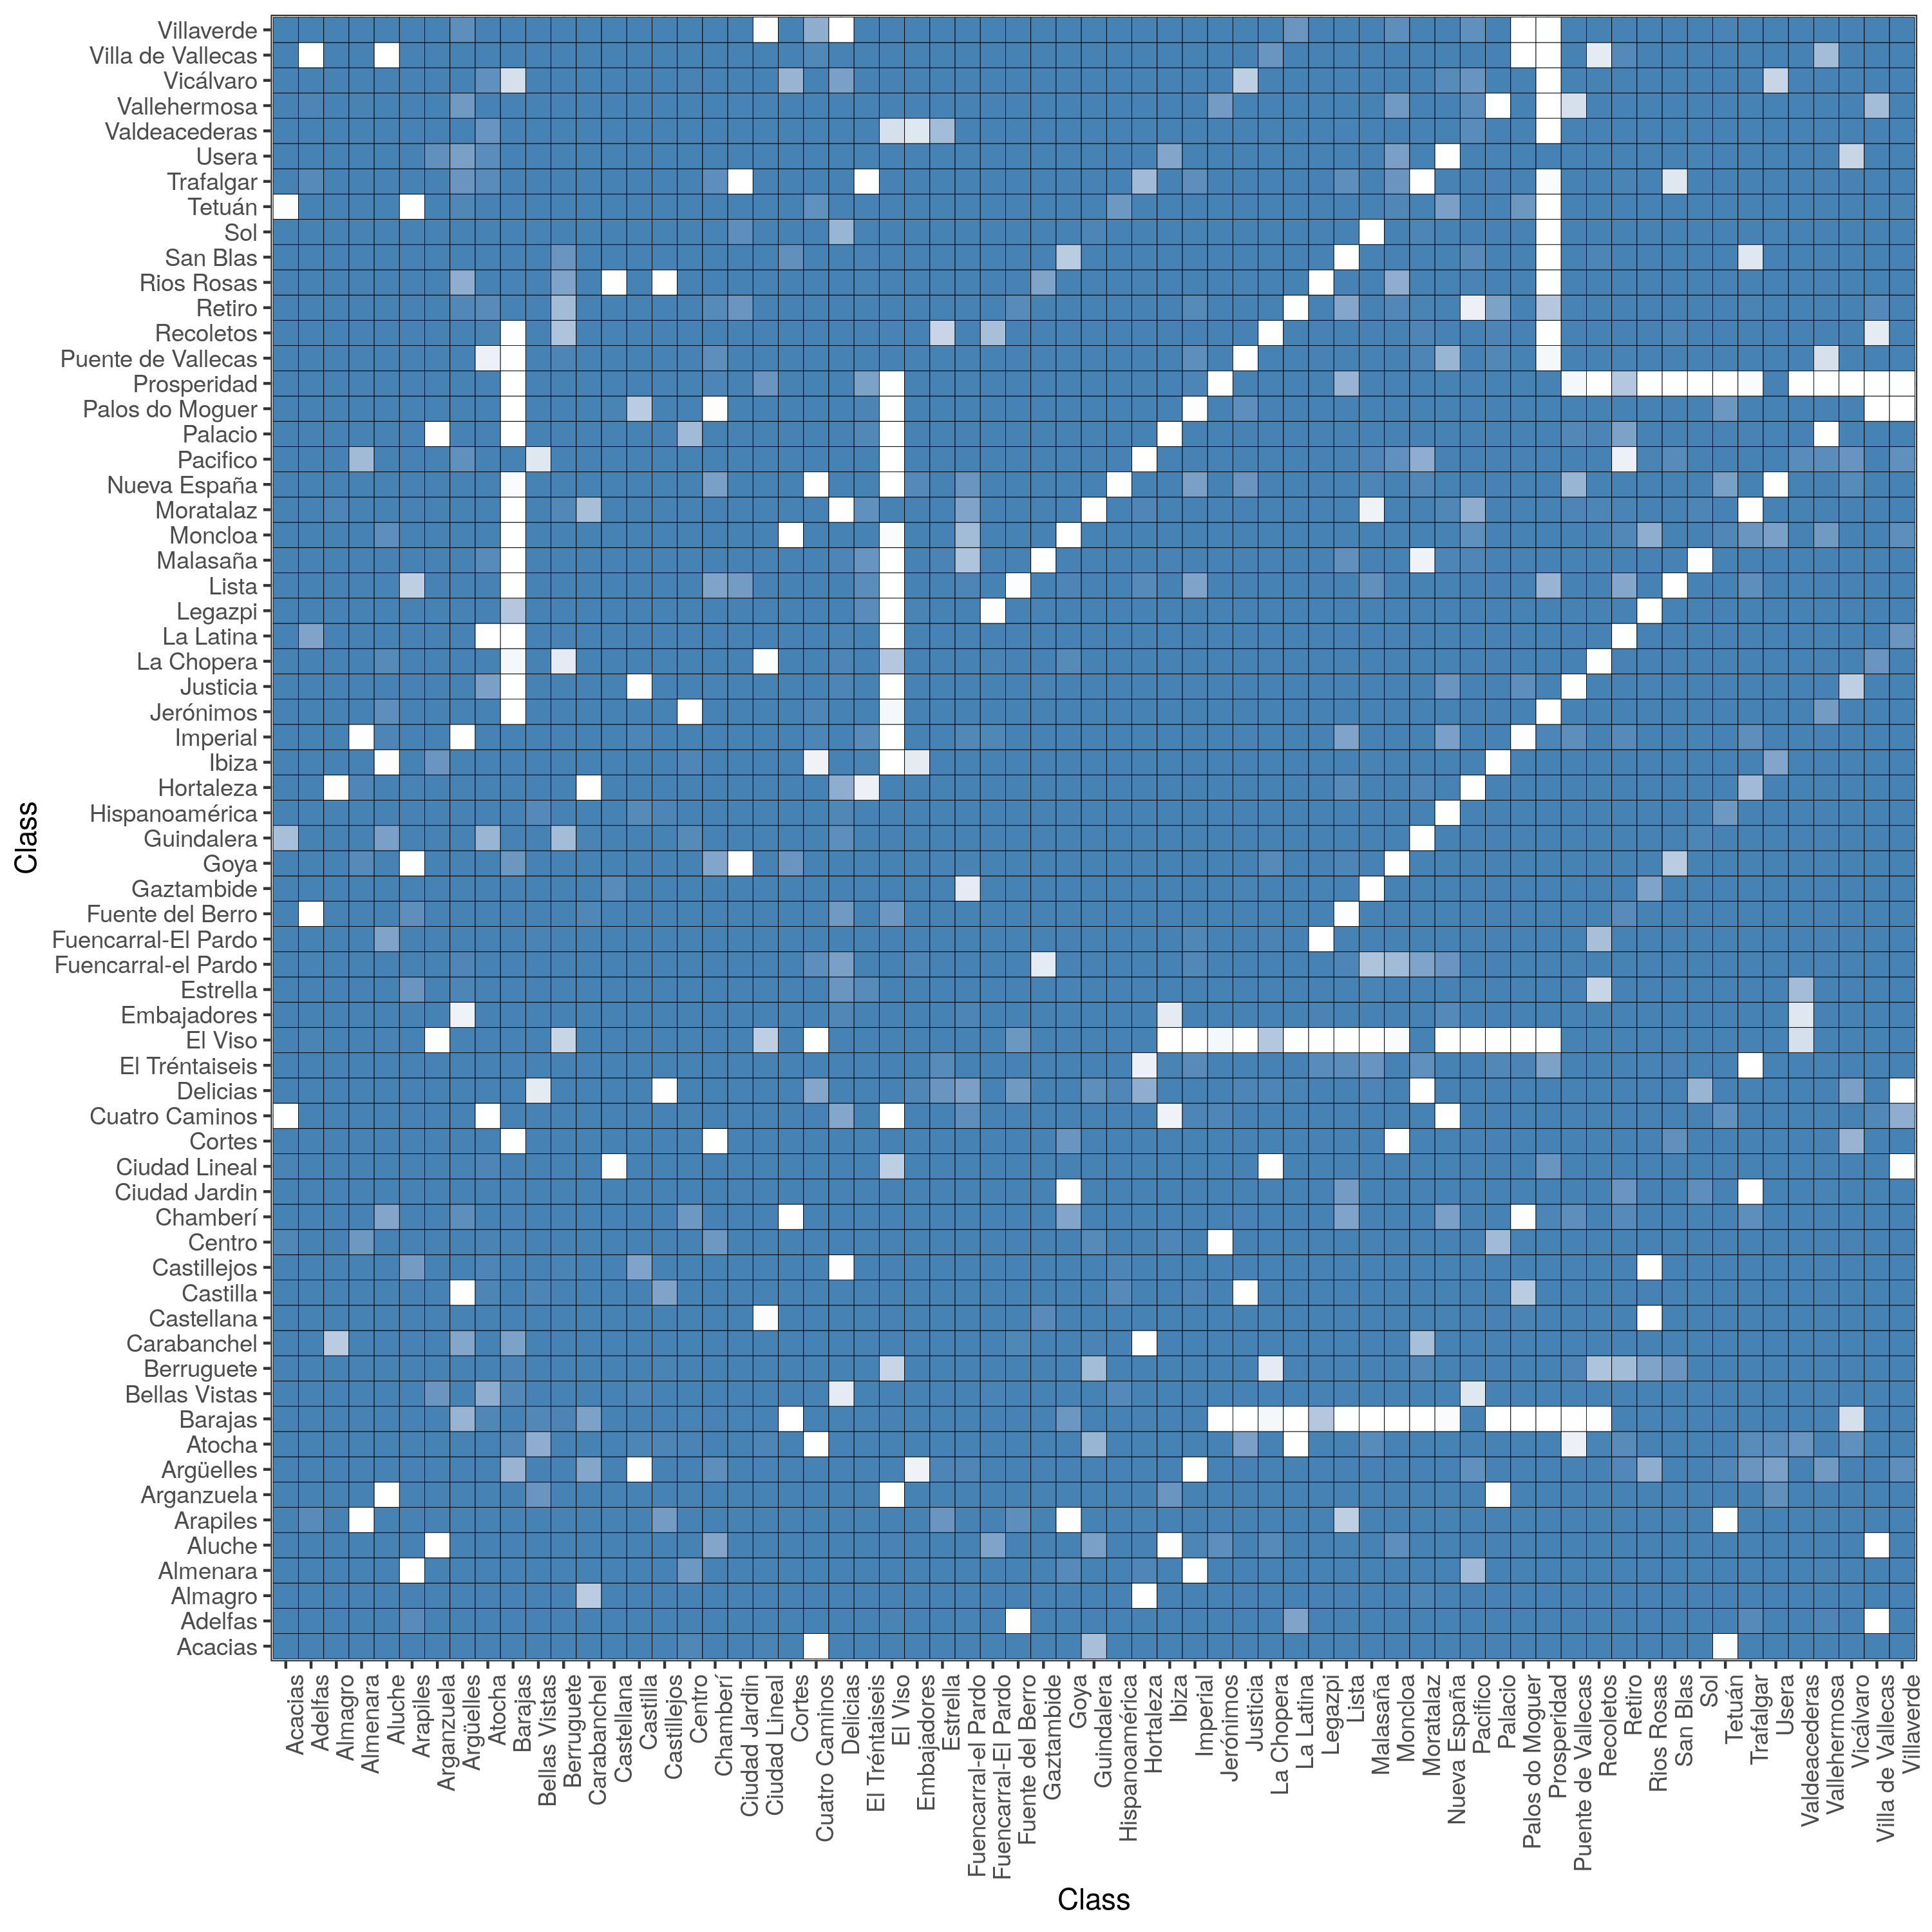

In [14]:
tky<-TukeyHSD(aov( formula=Square.Meters~Neighbourhood, data=df_madrid ))
tky.result<-data.frame(tky$Neighbourhood)
cn <-sort(unique(df_madrid$Neighbourhood))
resm <- matrix(NA, length(cn),length(cn))
rownames(resm) <- cn
colnames(resm) <- cn
resm[lower.tri(resm) ] <- round(tky.result$p.adj,4)
resm[upper.tri(resm) ] <- t(resm)[upper.tri(resm)] 
diag(resm) <- 1
library(ggplot2)
library(reshape2)
dfResm <- melt(resm)
options(repr.plot.height=10,repr.plot.width=10) 
ggplot(dfResm, aes(x=Var1, y=Var2, fill=value))+
  geom_tile(colour = "black")+
  scale_fill_gradient(low = "white",high = "steelblue")+
  ylab("Class")+xlab("Class")+theme_bw()+
  theme(axis.text.x = element_text(angle = 90, hjust = 1),legend.position="none")

Usando como variable de distancia: 1-resm
Dibuja un dendrograma de los diferentes barrios.


In [15]:
library(dendextend)
mad.dist<- as.dist(1 - resm)
mad.tree <- hclust(mad.dist, method="complete")
mad.dend <- as.dendrogram(mad.tree)


---------------------
Welcome to dendextend version 1.13.4
Type citation('dendextend') for how to cite the package.

Type browseVignettes(package = 'dendextend') for the package vignette.
The github page is: https://github.com/talgalili/dendextend/

Suggestions and bug-reports can be submitted at: https://github.com/talgalili/dendextend/issues
Or contact: <tal.galili@gmail.com>

	To suppress this message use:  suppressPackageStartupMessages(library(dendextend))
---------------------



Attaching package: ‘dendextend’


The following object is masked from ‘package:stats’:

    cutree




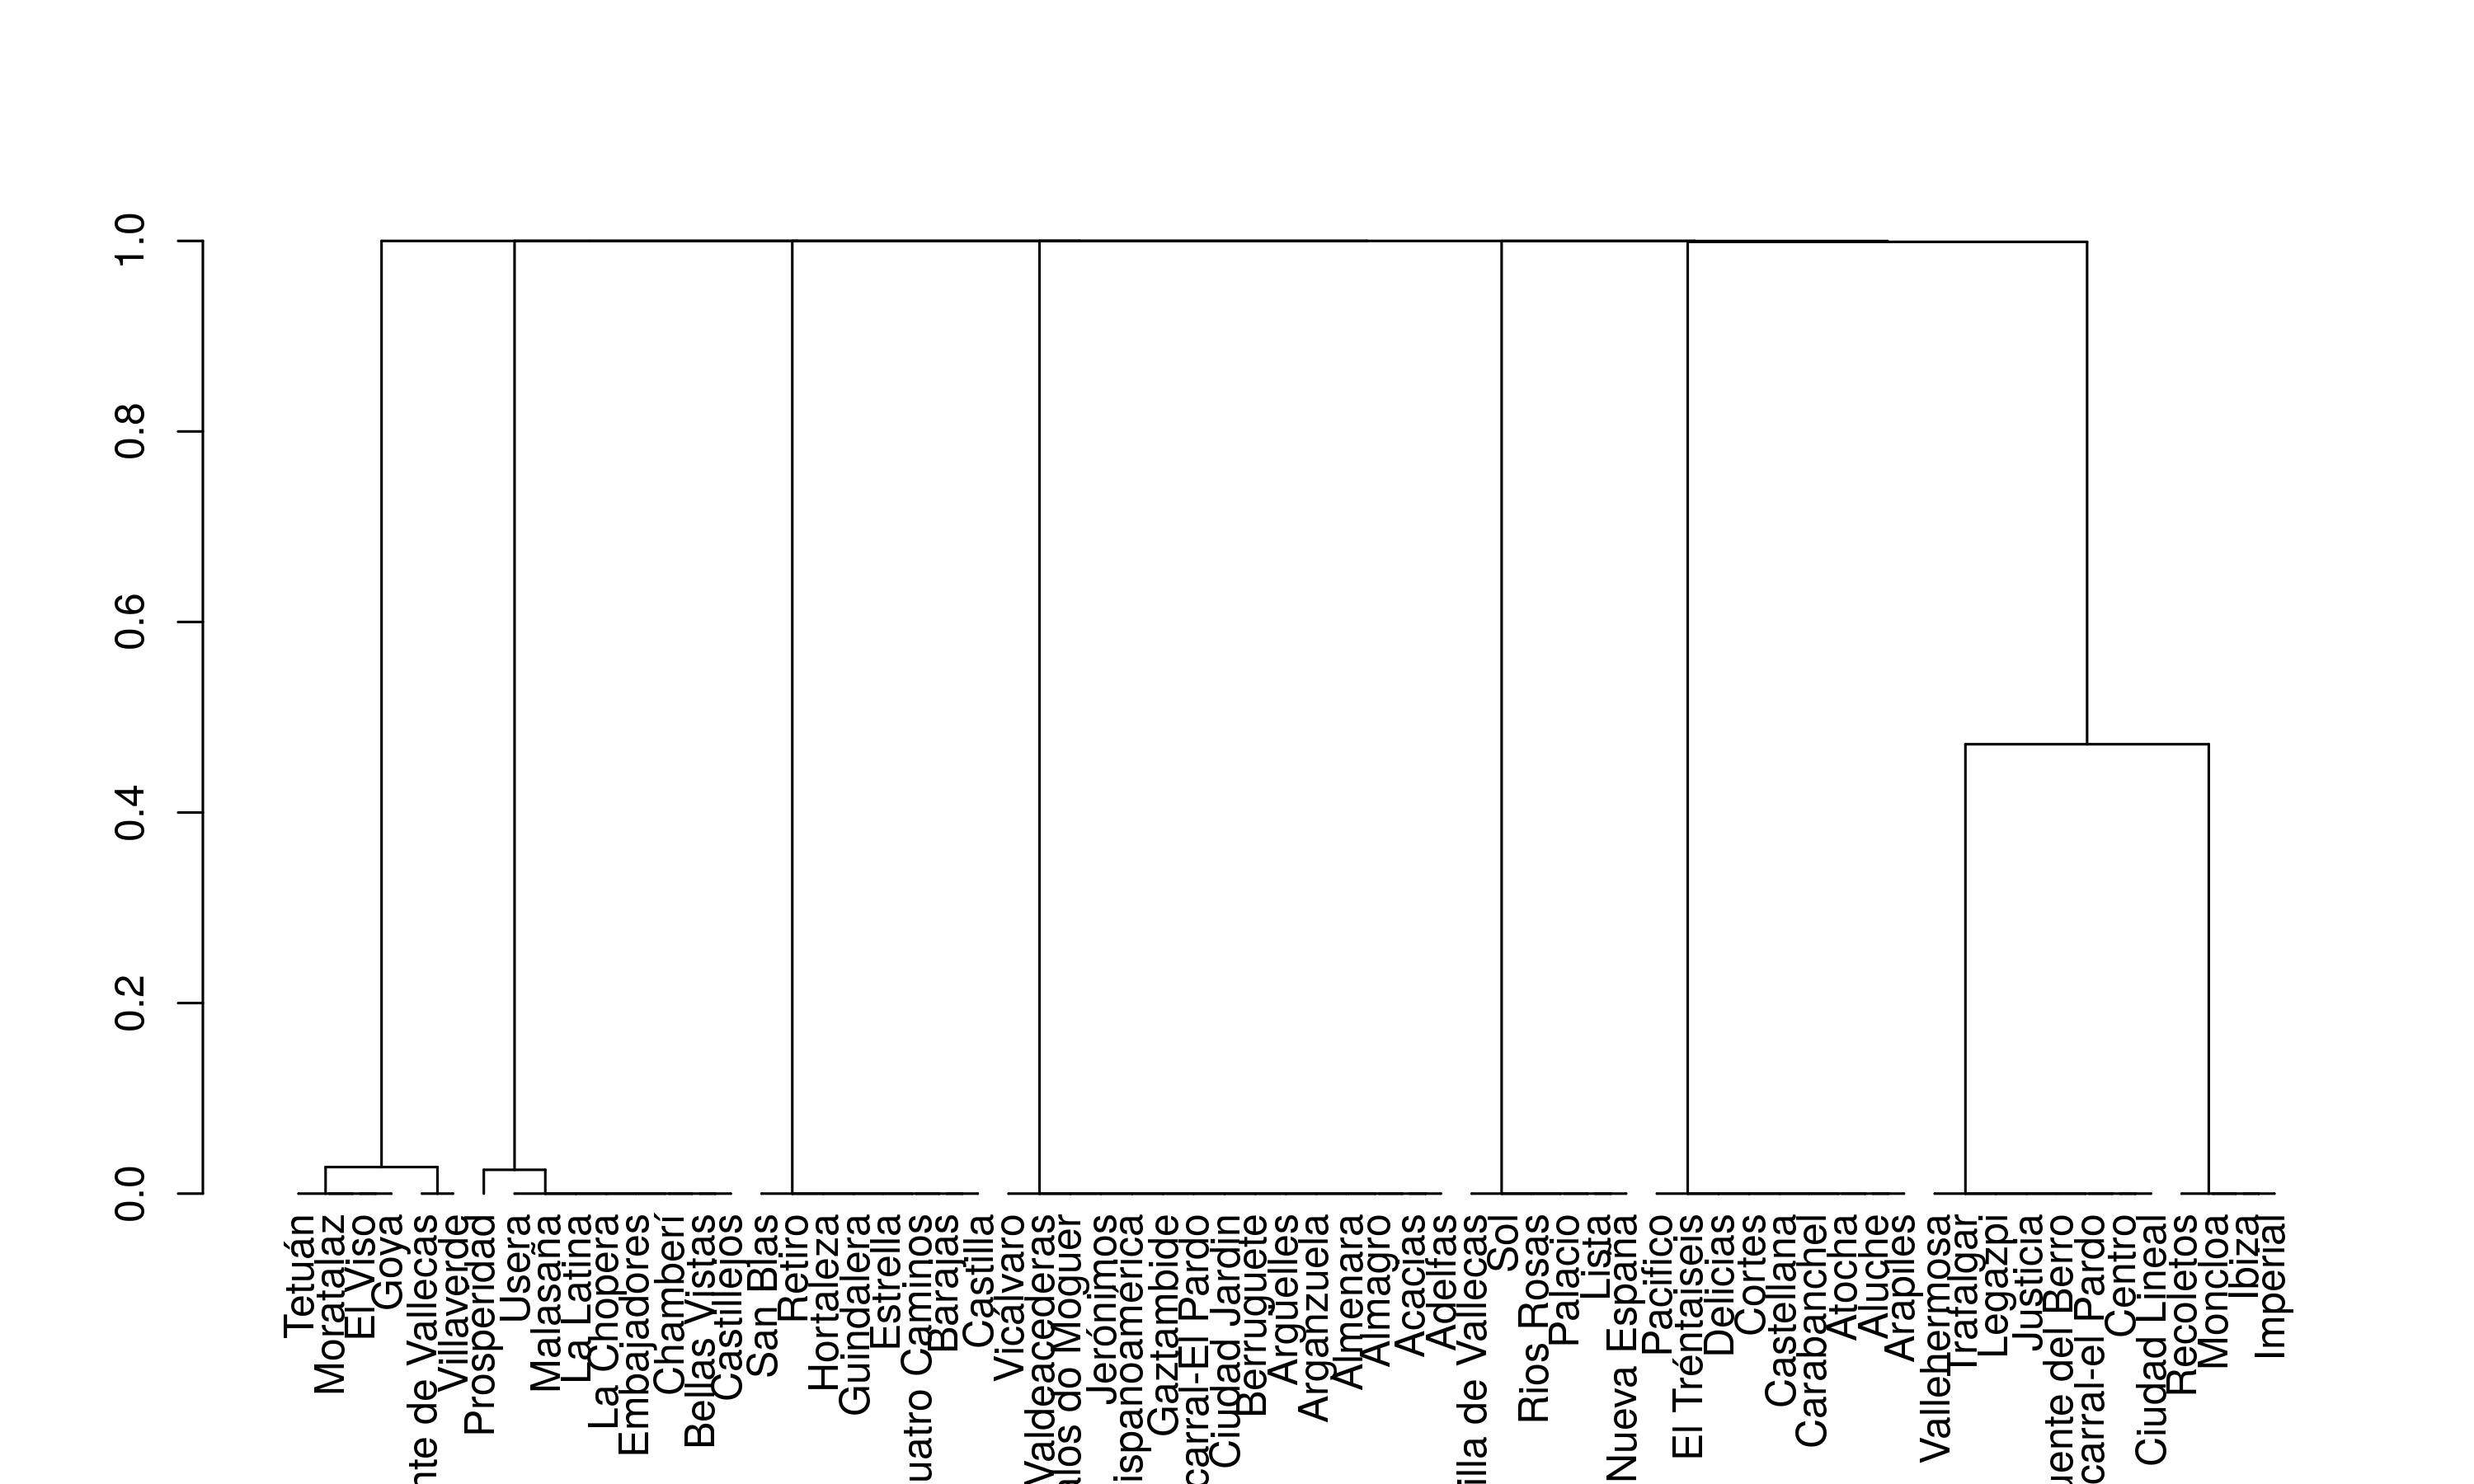

In [16]:
options(repr.plot.height=6,repr.plot.width=10) 
plot(mad.dend)

Estableciendo un punto de corte en 0.9, ¿cuantos clusters aparecen?

clusters
 1  2  3  4  5  6  7 
15  9  8  9 12  6  6 

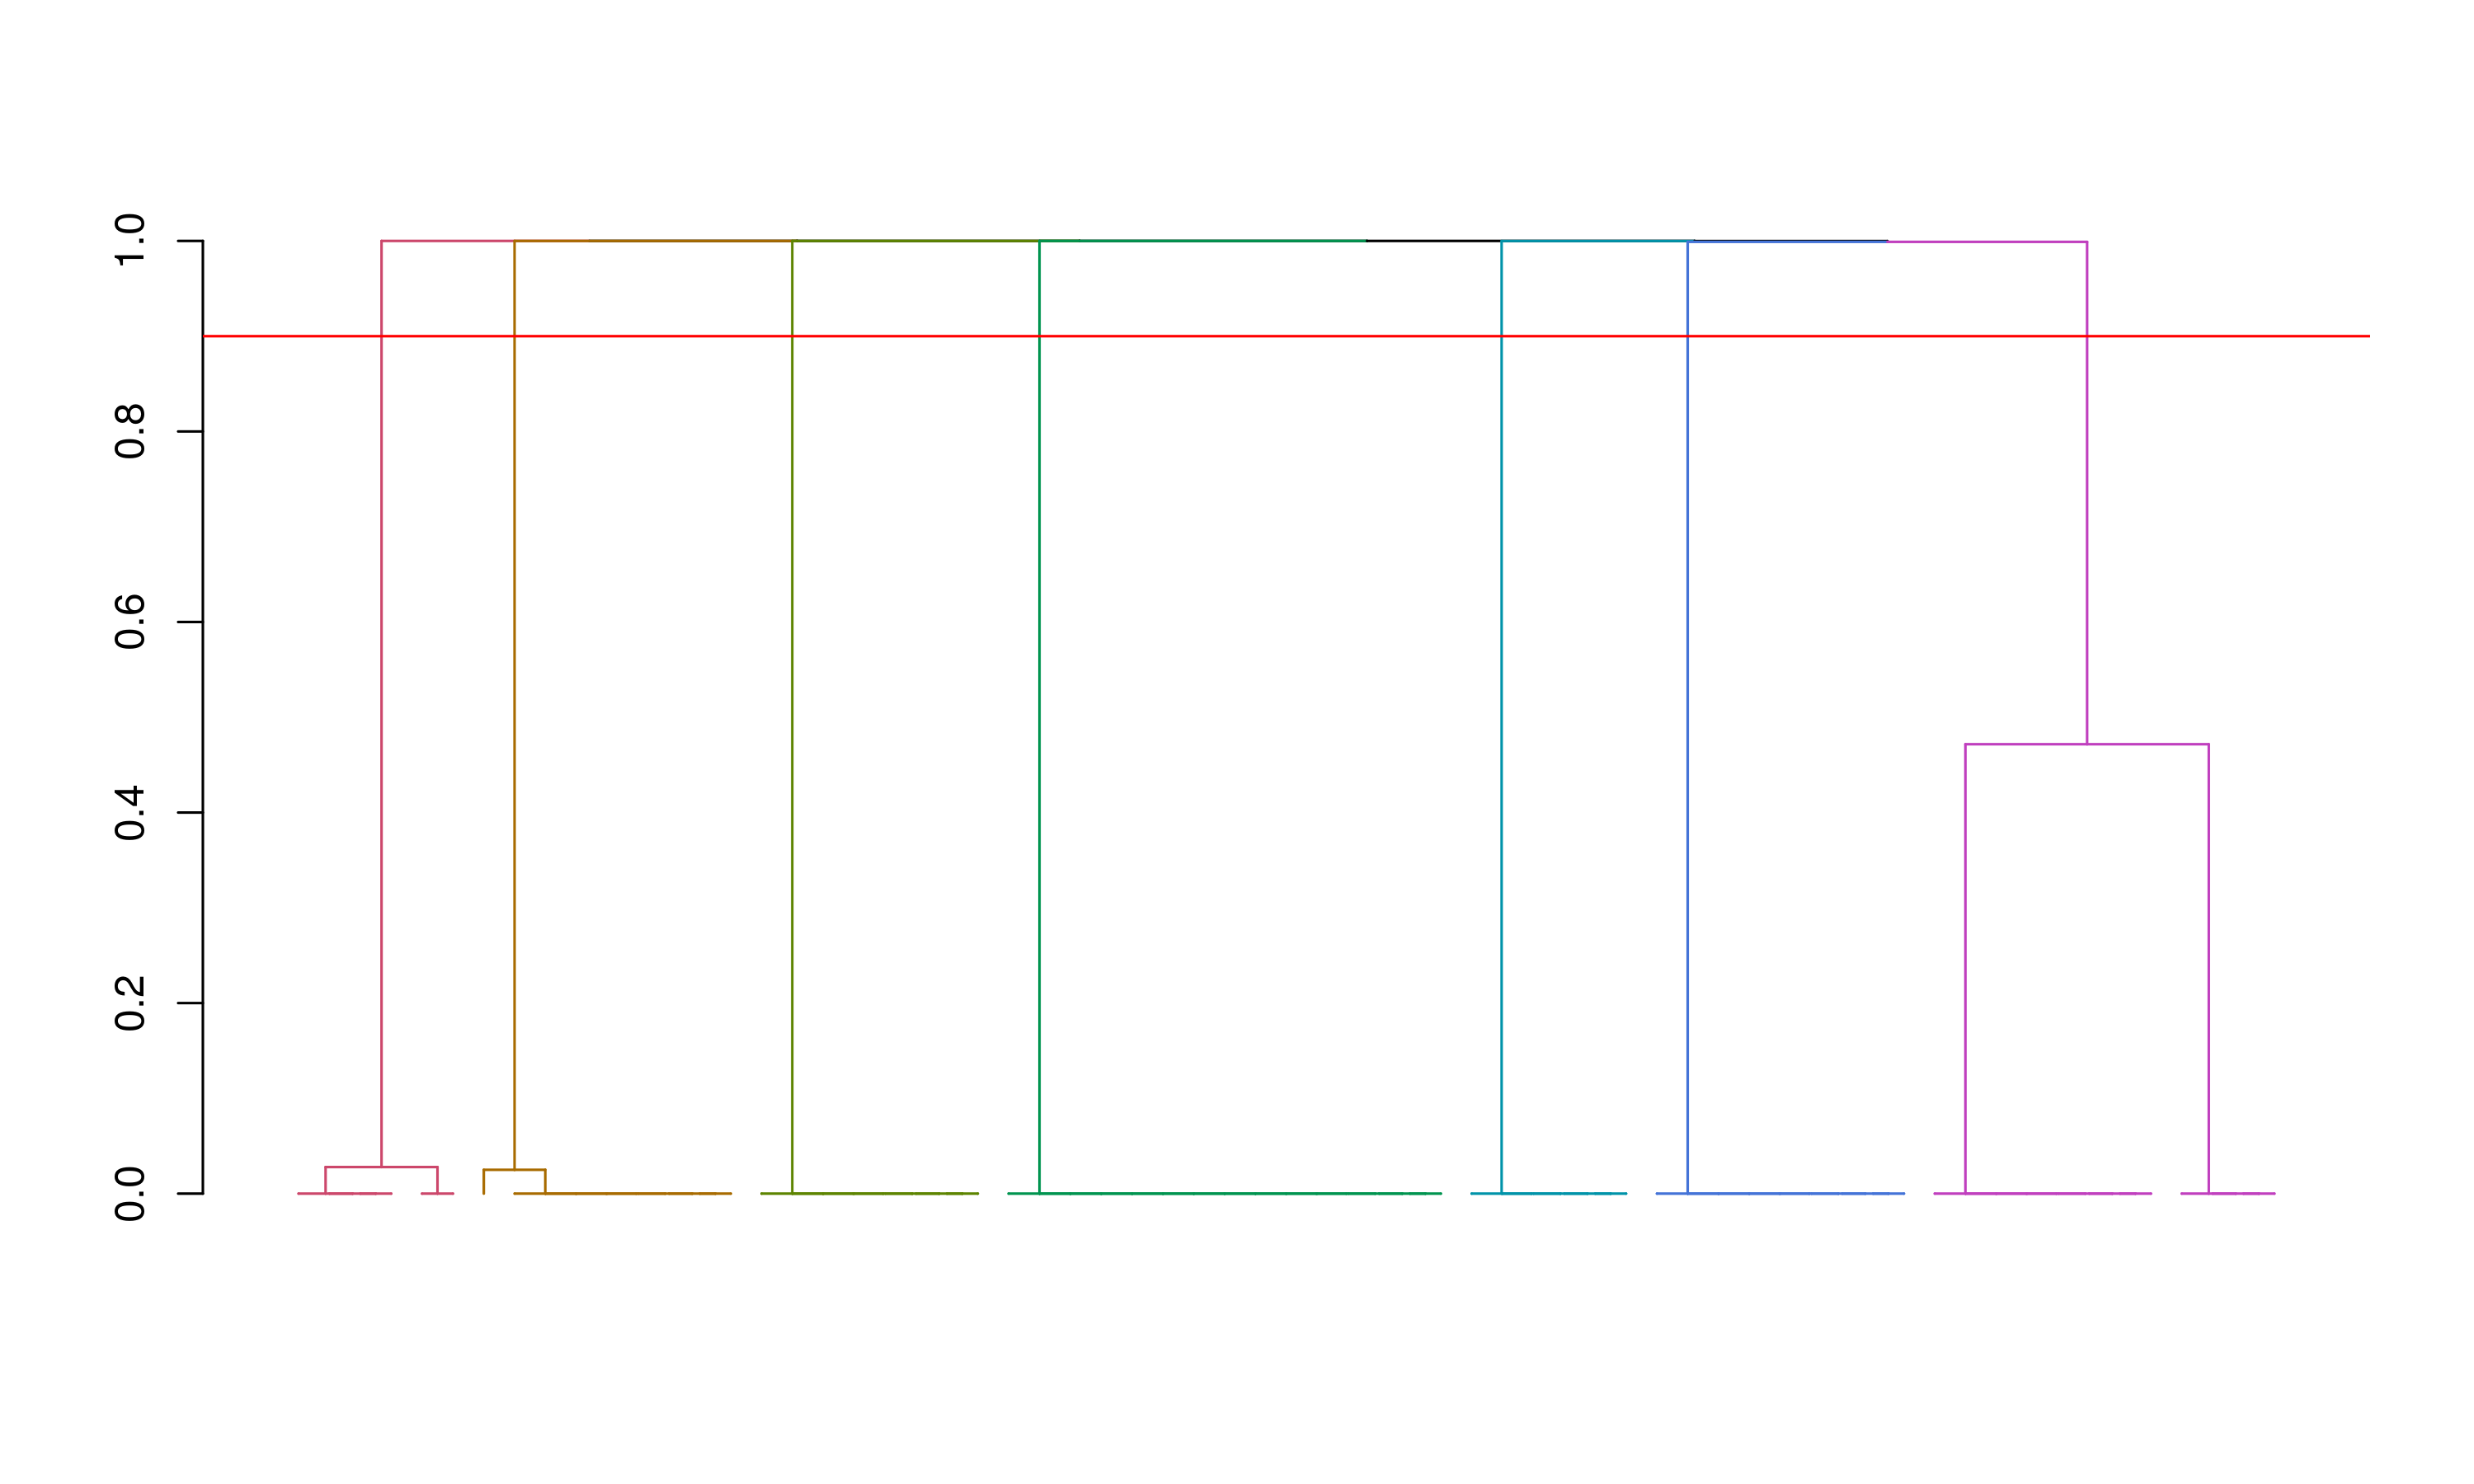

In [17]:
clusters <- cutree(mad.dend, h=0.9)
table(clusters)
options(repr.plot.height=6,repr.plot.width=10) 
plot(color_branches(mad.dend, h=0.9),leaflab="none")
abline(h=0.9,col="red")

Vamos a crear una nueva columna en el dataframe df_madrid con un nuevo identificador marcado por los clusters obtenidos. Esta columna la llamaremos neighb_id

In [18]:
id <- data.frame('Neighbourhood'=names(clusters),'neighb_id'=clusters)
df_madrid <- merge(df_madrid, id, by='Neighbourhood')

In [19]:
df_madrid$neighb_id <- as.factor(df_madrid$neighb_id)
summary(df_madrid)

     Neighbourhood   Accommodates      Bathrooms        Bedrooms     
 Malasaña   : 679   Min.   : 1.000   Min.   :0.000   Min.   : 0.000  
 Embajadores: 585   1st Qu.: 3.000   1st Qu.:1.000   1st Qu.: 1.000  
 La Latina  : 571   Median : 4.000   Median :1.000   Median : 1.000  
 Sol        : 536   Mean   : 4.101   Mean   :1.248   Mean   : 1.453  
 Cortes     : 441   3rd Qu.: 5.000   3rd Qu.:1.000   3rd Qu.: 2.000  
 Justicia   : 384   Max.   :16.000   Max.   :6.500   Max.   :10.000  
 (Other)    :2405                    NA's   :14      NA's   :7       
      Beds            Price         Square.Feet     Guests.Included 
 Min.   : 1.000   Min.   : 10.00   Min.   :   0.0   Min.   : 1.000  
 1st Qu.: 1.000   1st Qu.: 56.00   1st Qu.:   0.0   1st Qu.: 1.000  
 Median : 2.000   Median : 75.00   Median : 237.0   Median : 2.000  
 Mean   : 2.393   Mean   : 88.74   Mean   : 392.6   Mean   : 1.952  
 3rd Qu.: 3.000   3rd Qu.:100.00   3rd Qu.: 646.0   3rd Qu.: 2.000  
 Max.   :16.000   Max.   :

Vamos a crear dos grupos, uno test y otro train.

Tratamos de predecir los metros cuadrados en función del resto de columnas del dataframe.

In [20]:
idx<-sample(1:nrow(df_madrid),0.7*nrow(df_madrid))
dfmadrid.train<-df_madrid[idx,]
dfmadrid.test<-df_madrid[-idx,]
paste("Número de muestras training:",nrow(dfmadrid.train))
paste("Número de muestras testing:",nrow(dfmadrid.test))

[1] "Número de muestras training: 3920"

[1] "Número de muestras testing: 1681"

In [36]:
model<-lm(data=dfmadrid.train, formula = Square.Meters ~ neighb_id+Guests.Included+Bathrooms+Bedrooms+Beds)
summary(model)

dfmadrid.train$m2pred<-predict(model,dfmadrid.train)
dfmadrid.test$m2pred<-predict(model,dfmadrid.test)


Call:
lm(formula = Square.Meters ~ neighb_id + Guests.Included + Bathrooms + 
    Bedrooms + Beds, data = dfmadrid.train)

Residuals:
     Min       1Q   Median       3Q      Max 
-104.141  -11.249   -0.636    8.602  162.933 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)       11.768      9.633   1.222 0.224338    
neighb_id2       -17.609     11.055  -1.593 0.113931    
neighb_id3       -36.255     13.288  -2.729 0.007362 ** 
neighb_id4       -20.737      8.642  -2.400 0.018014 *  
neighb_id5       -18.886     10.958  -1.723 0.087506 .  
neighb_id6       -19.536     16.521  -1.182 0.239459    
neighb_id7       -13.516      9.245  -1.462 0.146464    
Guests.Included   -4.348      2.491  -1.745 0.083579 .  
Bathrooms         34.378      6.254   5.497 2.36e-07 ***
Bedrooms          15.149      4.369   3.467 0.000741 ***
Beds               6.110      2.369   2.579 0.011173 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residu

Mirad el histograma de los residuos sobre el conjunto de test para evaluar la calidad de vuestro modelo

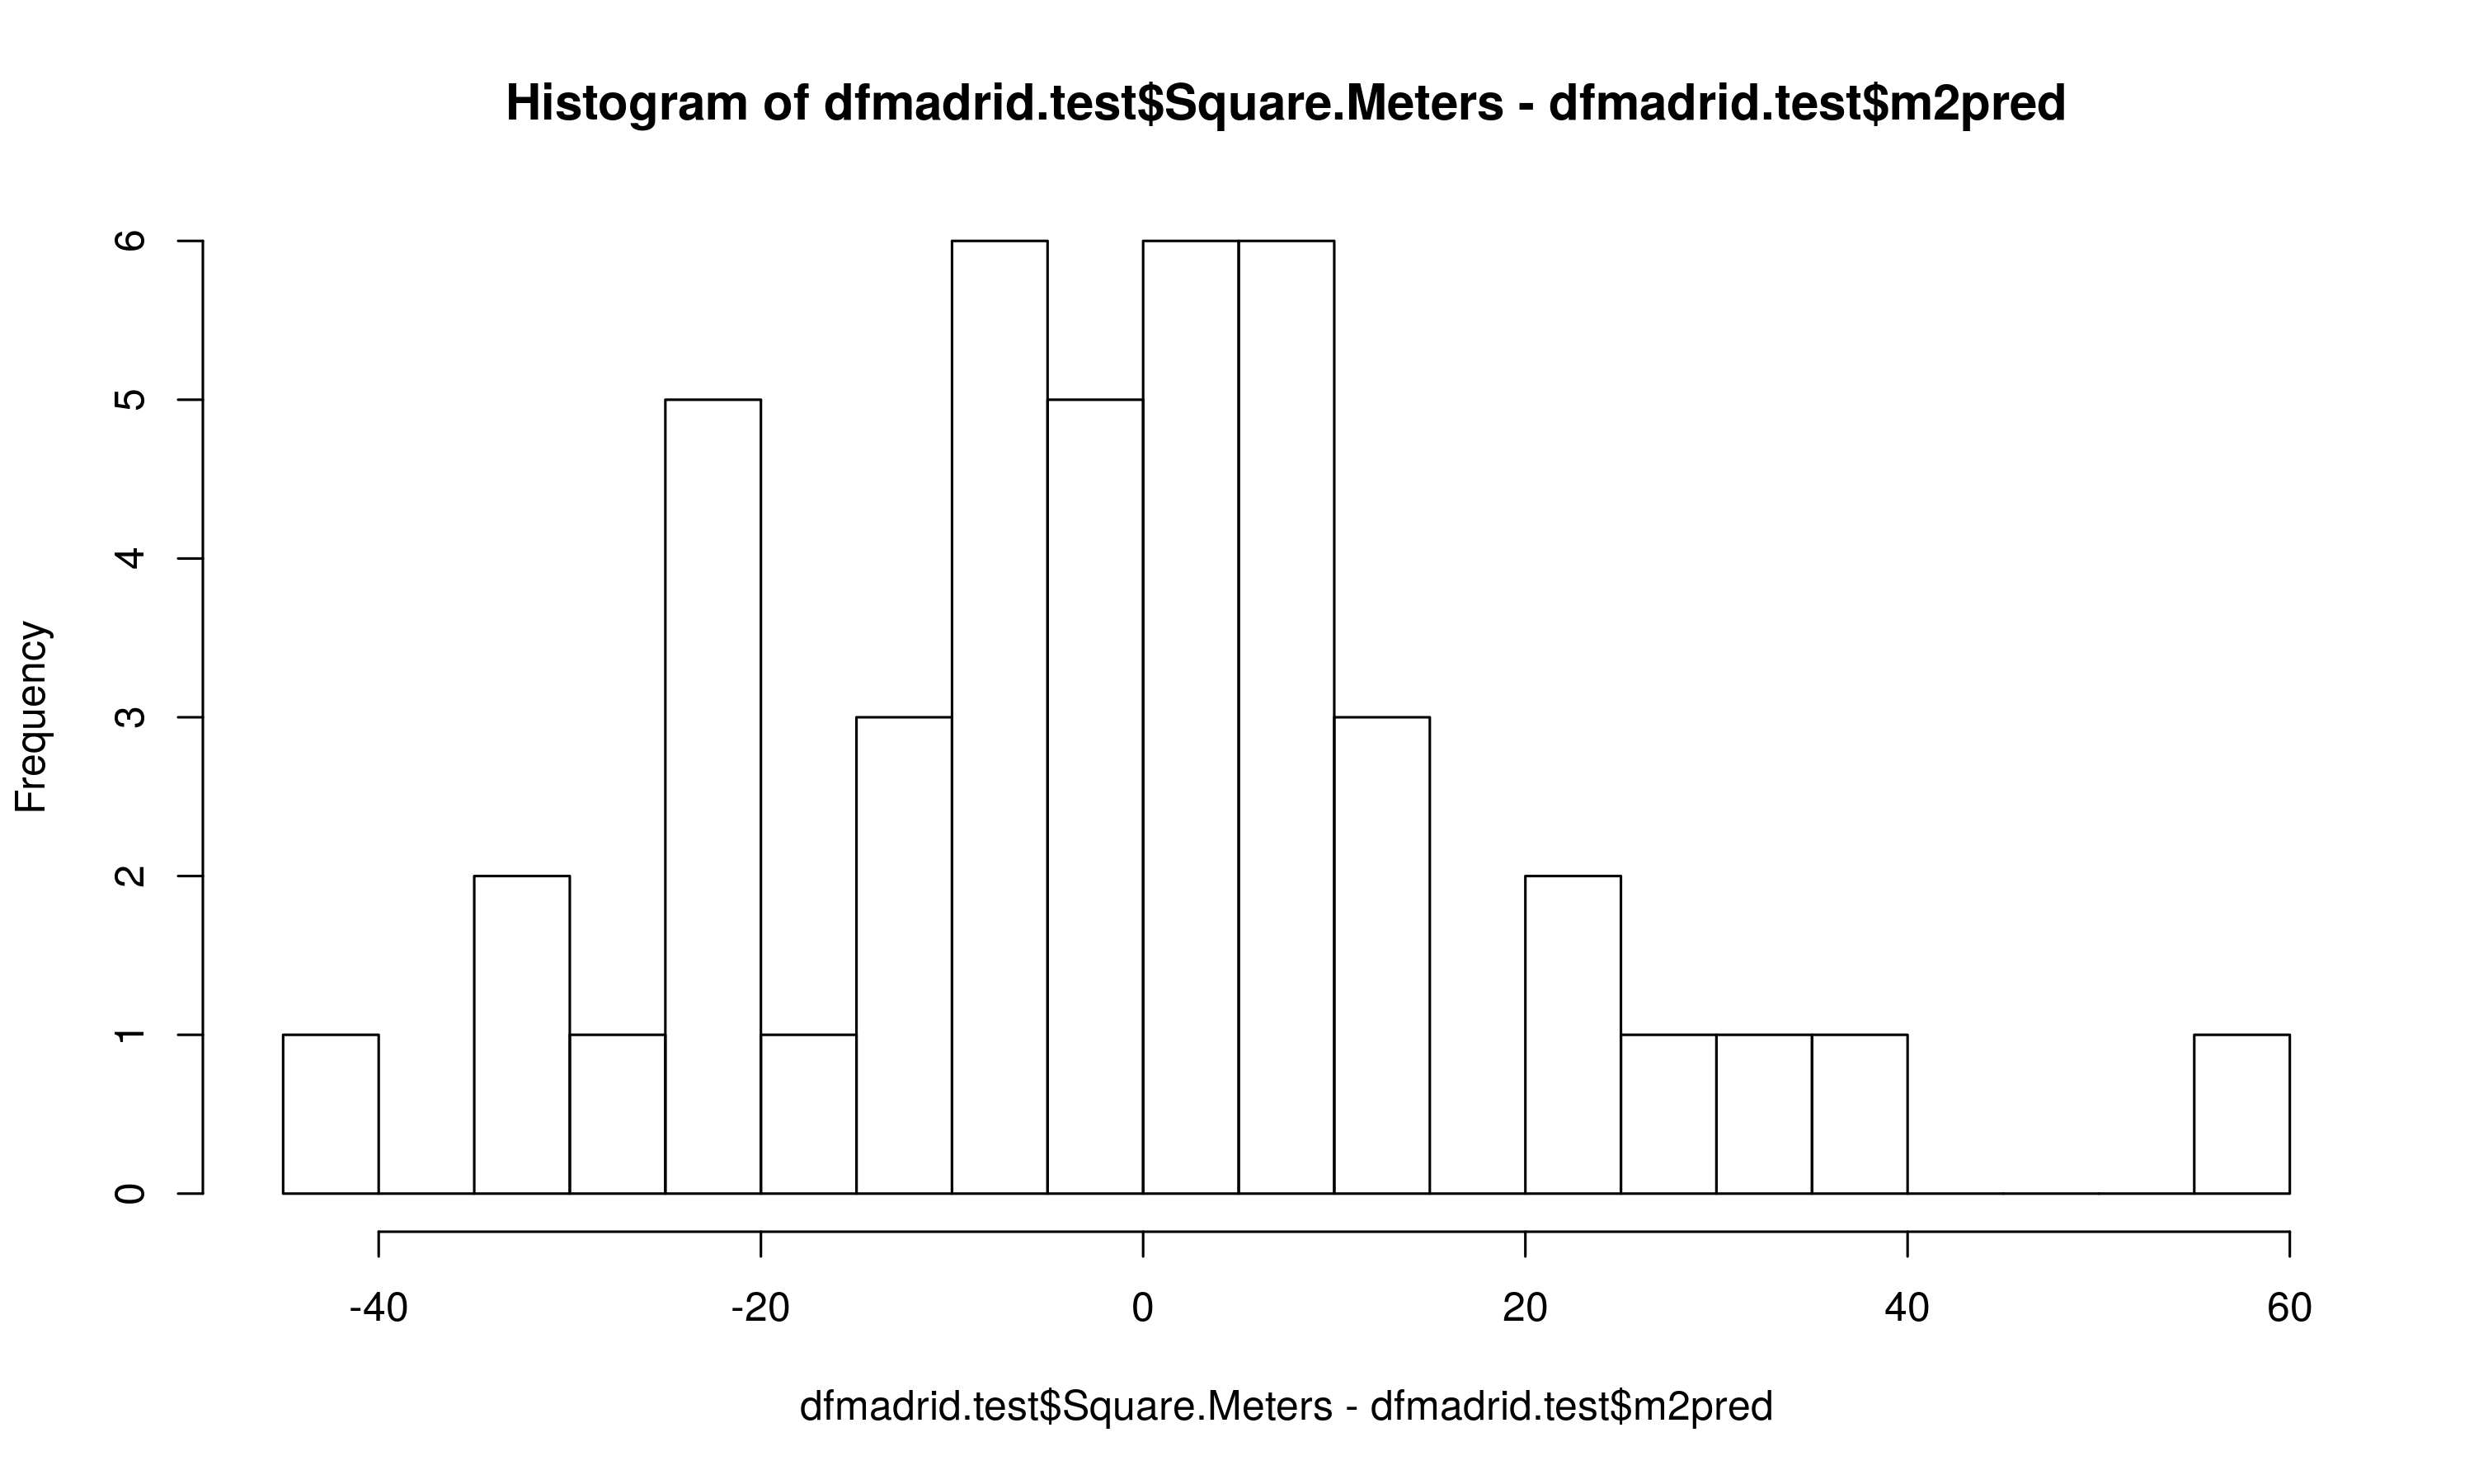

In [22]:
hist(dfmadrid.test$Square.Meters-dfmadrid.test$m2pred,20)

Si tuvieramos un anuncio de un apartamento para 6 personas (Accommodates) con un precio de 80€/noche y 3 habitaciones en el barrio de Sol.
¿Cuantos metros cuadrados tendría?
¿Como varía sus metros cuadrados con cada habitación adicional?

In [35]:
select(df_madrid, Neighbourhood, neighb_id) %>%  filter(Neighbourhood=="Sol") %>% distinct (Neighbourhood,neighb_id)

df_madridsol <- data.frame(
    "Accommodates" = 6, 
    "Price" = 80, 
    "Bedrooms" = 3,
    "neighb_id" = 7,
    "Guests.Included" = 3,
    "Bathrooms"= 2,
    "Beds"= 3)

df_madridsol$neighb_id <- as.factor(df_madridsol$neighb_id)
df_madridsol$m2pred<-predict(model,df_madridsol)
df_madridsol

model$coefficients

Neighbourhood,neighb_id
<fct>,<fct>
Sol,7


Accommodates,Price,Bedrooms,neighb_id,Guests.Included,Bathrooms,Beds,m2pred
<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
6,80,3,7,3,2,3,117.7429


(Intercept)      neighb_id2      neighb_id3      neighb_id4      neighb_id5 
      11.768254      -17.608708      -36.255064      -20.737258      -18.885662 
     neighb_id6      neighb_id7 Guests.Included       Bathrooms        Bedrooms 
     -19.535826      -13.516305       -4.347758       34.377648       15.149486 
           Beds 
       6.110151

*Un piso con esas característiccas tendría 117.7429 metros cuadrados. Además, por cada habitación adicional los metros cuadrados variarían en 15.149*

Rellenar los Square.Meters con valor NA con el estimado con el modelo anterior.

In [34]:
df_madrid$Square.Meters[is.na(df_madrid$Square.Meters)] <- predict(model,df_madrid)
sapply(df_madrid, function(x) sum(is.na(x)))
head(df_madrid)

Neighbourhood         Accommodates            Bathrooms 
                   0                    0                   14 
            Bedrooms                 Beds                Price 
                   7                    8                    5 
         Square.Feet      Guests.Included         Extra.People 
                5254                    0                    0 
Review.Scores.Rating             Latitude            Longitude 
                 833                    0                    0 
       Square.Meters            neighb_id 
                   0                    0

,Neighbourhood,Accommodates,Bathrooms,Bedrooms,Beds,Price,Square.Feet,Guests.Included,Extra.People,Review.Scores.Rating,Latitude,Longitude,Square.Meters,neighb_id
,<fct>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<fct>
1,Acacias,3,1,1,1,122,NA,1,0,NA,40.39957,-3.702361,63.05778,1
2,Acacias,2,1,1,1,60,NA,1,0,80,40.40030,-3.701024,63.05778,1
3,Acacias,6,1,2,3,50,NA,2,10,68,40.40226,-3.712753,86.07981,1
4,Acacias,2,1,2,1,75,NA,1,0,NA,40.40270,-3.703143,78.20727,1
5,Acacias,4,1,1,2,59,NA,2,10,95,40.39933,-3.701477,64.82017,1
6,Acacias,3,1,1,2,45,NA,1,0,NA,40.40093,-3.703781,69.16793,1


Usar PCA para encontrar el apartamento más cercano a uno dado.

Este algoritmo nos ayudaría a dado un apartamento que el algoritmo nos devolvería los 5 apartamentos más similares.


Crearemos una función tal que le pasemos un apartamento con los siguientes datos:
* Accommodates	
* Bathrooms	
* Bedrooms	
* Beds	
* Price	
* Guests.Included	
* Extra.People	
* Review.Scores.Rating	
* Latitude	
* Longitude	
* Square.Meters

y nos devuelva los 5 más similares de:

In [30]:
PCAmadrid <- df_madrid
keep<-c('Accommodates','Bathrooms','Bedrooms','Beds','Price','Guests.Included','Extra.People','Review.Scores.Rating','Latitude','Longitude', 'Square.Meters')
PCAmadrid <- PCAmadrid[keep]
PCAmadrid <- na.omit(PCAmadrid)
prdfmadrid<-prcomp(PCAmadrid,center = TRUE, scale. = TRUE)
prdfmadrid

Standard deviations (1, .., p=11):
 [1] 2.0132169 1.1413056 1.0275163 1.0041278 0.9866659 0.8659763 0.7879897
 [8] 0.6972097 0.5801960 0.5167021 0.3824324

Rotation (n x k) = (11 x 11):
                            PC1         PC2         PC3         PC4
Accommodates         0.44796794 -0.05831654  0.08535992 -0.08785741
Bathrooms            0.38486487  0.09586126  0.12103852  0.21862804
Bedrooms             0.42657365  0.03399827  0.13979174  0.05638181
Beds                 0.43069263 -0.00580634  0.11924597 -0.02171771
Price                0.37436082  0.04683454  0.08943414  0.22378523
Guests.Included      0.33577146 -0.14581688 -0.28124640 -0.26959251
Extra.People         0.16022781 -0.19259247 -0.68501958 -0.44047857
Review.Scores.Rating 0.03792568 -0.14519854 -0.51239114  0.75283333
Latitude             0.02097037  0.65880542 -0.17428047 -0.04400175
Longitude            0.03040486  0.64299430 -0.27842439  0.04761929
Square.Meters        0.04877009  0.23900512  0.13233934 -0.2304109

In [31]:
prdfmadrid$rotation

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
Accommodates,0.44796794,-0.05831654,0.08535992,-0.08785741,0.047061932,-0.09555417,0.23040431,0.17001342,0.072303759,-0.275683185,-0.7786870215
Bathrooms,0.38486487,0.09586126,0.12103852,0.21862804,-0.008935595,0.14287202,-0.42872603,-0.12095344,-0.734463275,-0.147106537,0.0153775965
Bedrooms,0.42657365,0.03399827,0.13979174,0.05638181,0.031756852,-0.07370601,0.14102591,0.26278724,-0.037974219,0.832639197,0.0635752184
Beds,0.43069263,-0.00580634,0.11924597,-0.02171771,0.043354826,-0.12623125,0.28144192,0.34586996,0.094830508,-0.450795152,0.6090322135
Price,0.37436082,0.04683454,0.08943414,0.22378523,-0.020179041,0.23165159,-0.49491580,-0.24756345,0.661870609,-0.012918825,0.0323053644
Guests.Included,0.33577146,-0.14581688,-0.28124640,-0.26959251,0.047314918,-0.10318362,0.32026408,-0.75931386,-0.062093952,0.061836181,0.1205145688
Extra.People,0.16022781,-0.19259247,-0.68501958,-0.44047857,-0.054881022,0.15386141,-0.34551904,0.35524957,-0.017001895,0.030268072,0.0220420352
Review.Scores.Rating,0.03792568,-0.14519854,-0.51239114,0.75283333,-0.276644718,0.03311302,0.25804699,0.04727414,-0.004547567,-0.021095728,-0.0354788362
Latitude,0.02097037,0.65880542,-0.17428047,-0.04400175,0.221686175,0.62676187,0.30089243,0.01466801,-0.001527669,-0.012637577,-0.0183622330
Longitude,0.03040486,0.64299430,-0.27842439,0.04761929,0.055258433,-0.68037674,-0.18910871,-0.01788201,0.051562169,-0.018463665,-0.0282613824


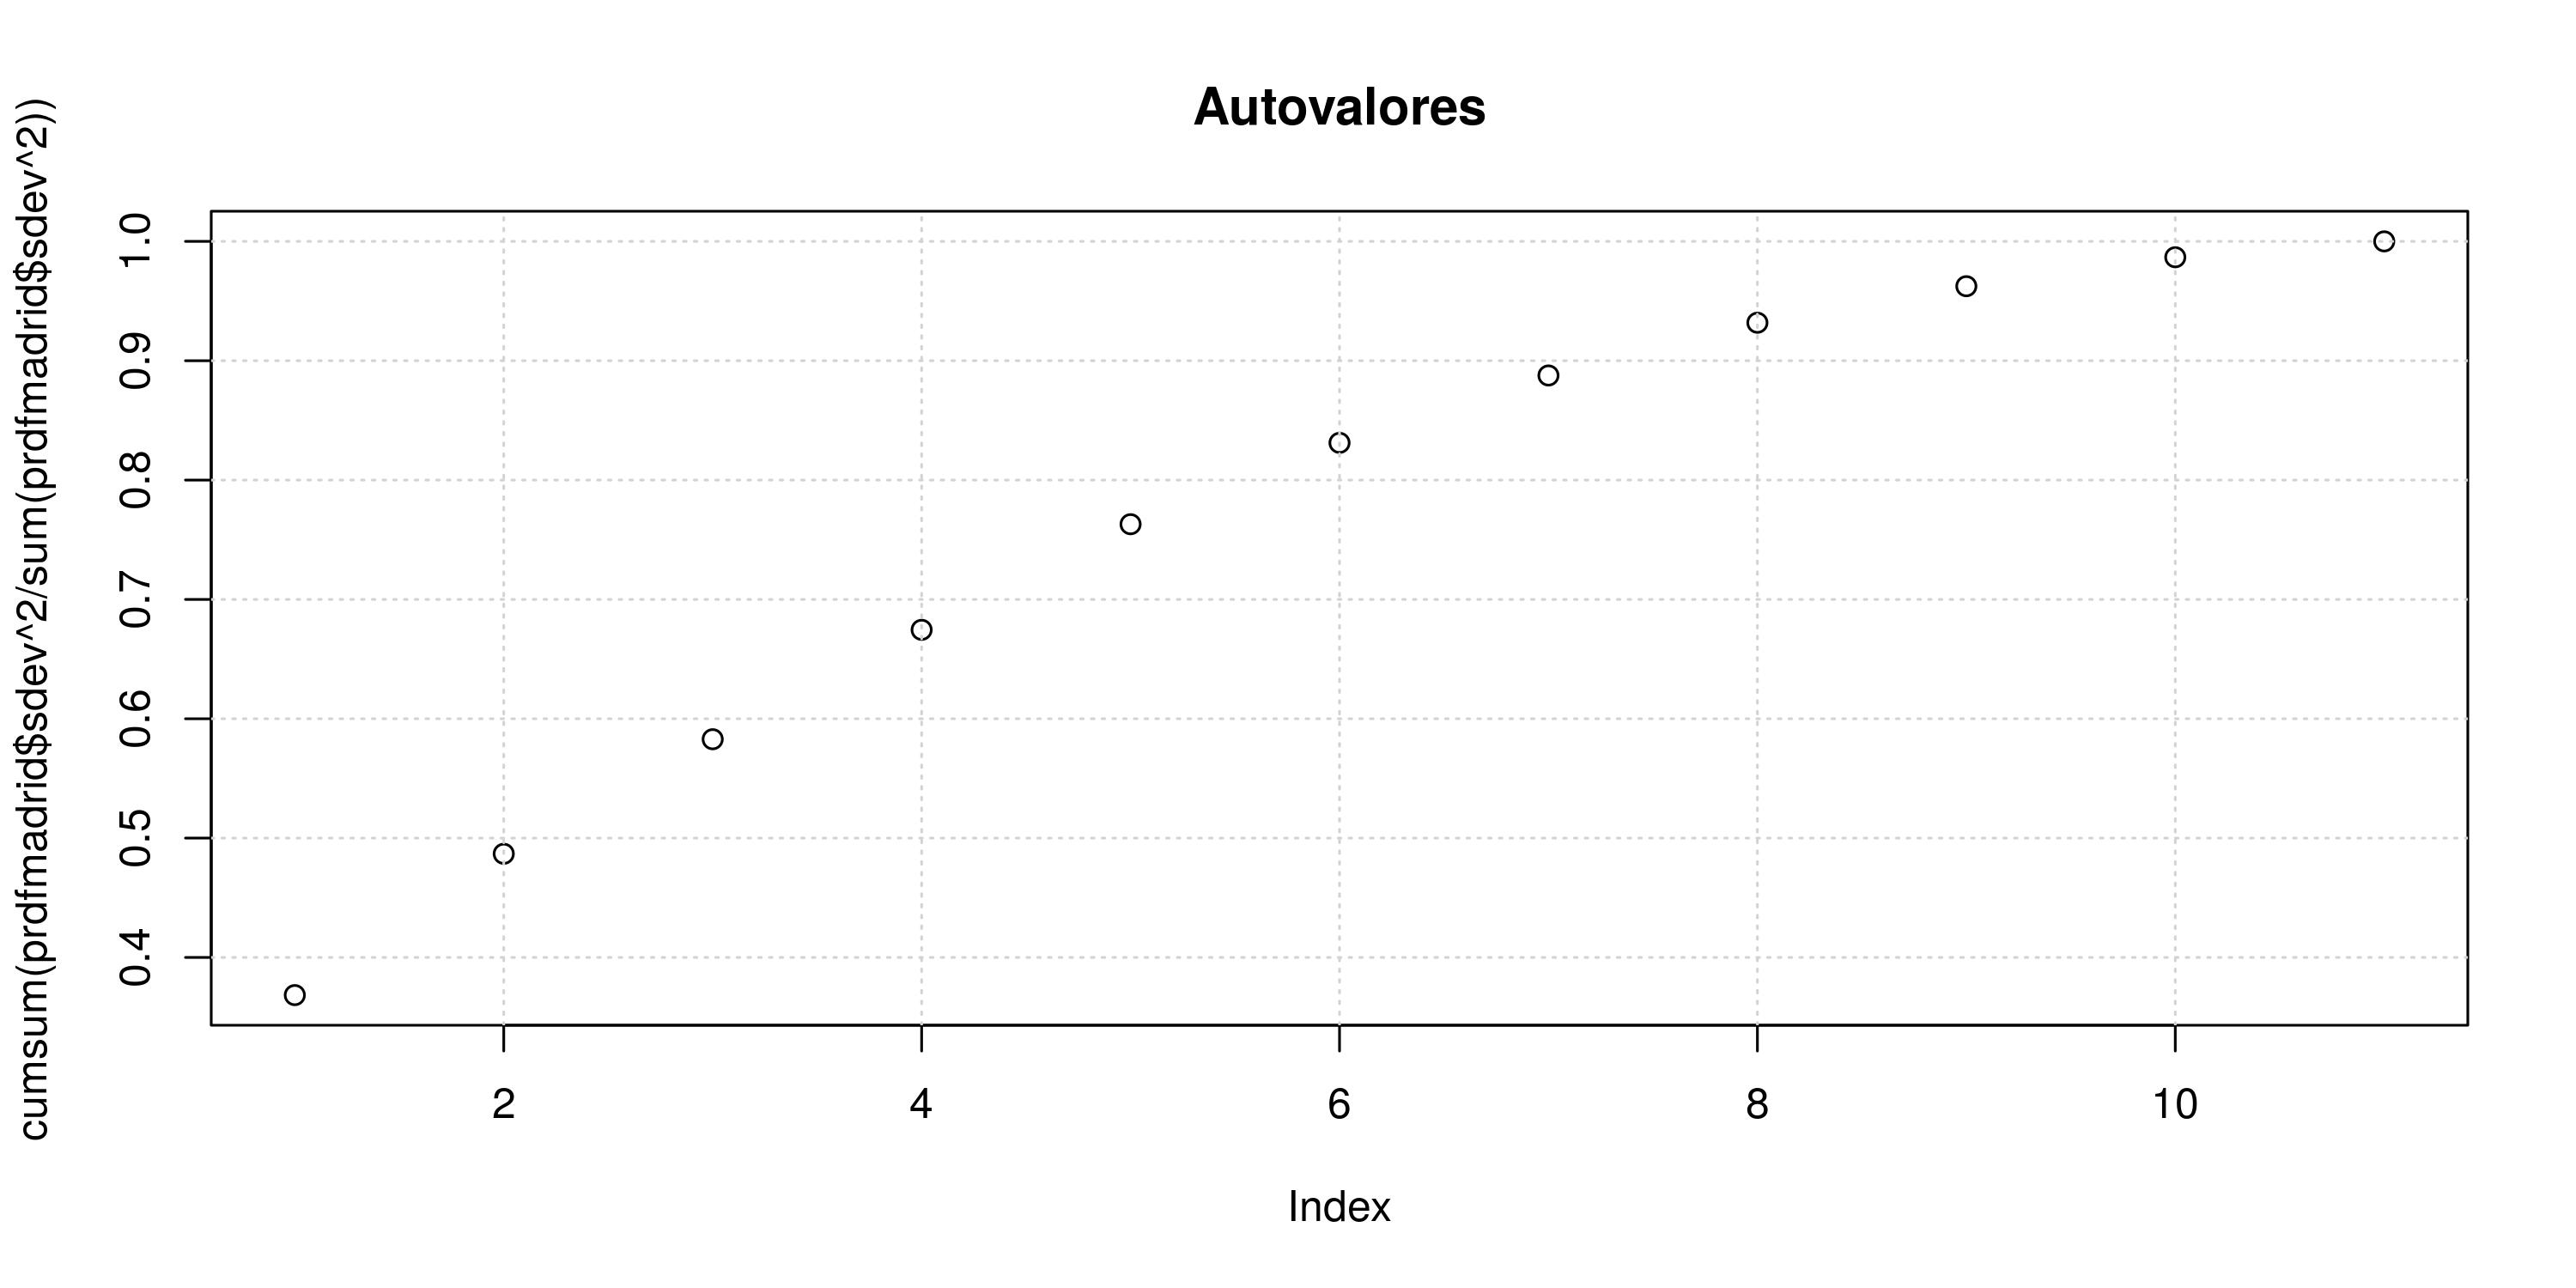

In [32]:
options(repr.plot.height=5,repr.plot.width=10) 
plot(cumsum(prdfmadrid$sdev^2/sum(prdfmadrid$sdev^2)),main="Autovalores")
grid()

*Gran parte de la varianza está en los 9 primeros autovalores, suman casi 1*

In [37]:
componentesPCA<-9
test_pca<-predict(prdfmadrid, newdata = df_madrid[1584,])
df_test<-data.frame(test_pca[,1:componentesPCA])
dist<-rowSums((df_test[rep(1, times = nrow(prdfmadrid$x)), ]-prdfmadrid$x)^2)
which.min(dist)
order(dist)

df_madrid[1584,]
df_madrid[3796,]
df_madrid[2317,]
df_madrid[3852,]
df_madrid[1194,]
df_madrid[3806,]


4488 
3796

[1] 3796 2317 3852 1194 3806 1379 3802  739 1407 4688  653 1270 3836 1359
  [15] 1572 3862 4442 2749  606 3918 2639 2296  620 1046 1144 3897 1201 1458
  [29] 1260 1157 4090 1213 2380  895 4469  652  668 1487 1943 1521 1567  910
  [43] 1051 3481  735 1391 2561 1922  375 1015 4337 4495 1235 1185 3926 1396
  [57] 2537 2642 1482 1523 1562 2288 2812 1397 4333 2008 1006 2809 1979 1464
  [71] 2391 1088 1200 1362  730 4123 1099 4406 2693 2554 1421 1569 3785   10
  [85] 1559 1252 1056 1165 1510 1516 2623    3 1558 1484 1414 1440 2467 1368
  [99] 1444 3840 2508   93 1214 3788 1207 1255 1077 1173 1101 3792 3780 1172
 [113] 4440 1312 2399 1112 1305 2625  914 2631 4394 2771 2662 1475 4293 2418
 [127] 2501 1202 3010 3855 3537 1177  629 1147 2297 4214 1348 1223 1204 4356
 [141]  747 1290 1553 1351  729 1317  776 1459 3494 1394 2600 3958 4456  751
 [155] 1140 4500 4168  922 1887 1236 3746 1010 3994 2327 1963 4487 1546 3542
 [169]  937 1133 4446 3811 1189 4680 3896 2552  761 4512 3829 3813 1068 3299
 [183] 1341 2221  763 2172 1461 3083 2692 3056  854 2208  605 2555 2648 3049
 [197] 1257 1098 3519 4249  861 2685 1852 2604 3982 2138 1417 4437 1358 2209
 [211] 4539  615 1483 2660 2385 1405 4474 3900 2044 1002 2528 3499  880 2514
 [225] 3898 2153 4675 2699 2180 1942 3371  888 1426 2392 2533 1114 1549 1925
 [239]  512 2375 1149  784 2525 1069 3284 3791 1174 1057 4008 4211 2289 3849
 [253]  665 1434 1974 3294 1570  648  657 3775 2602 4463 2107 1495 4271 2329
 [267] 1486  901 3689 1314 1923 1893 4507 2751 3980 3715  799 4516  935 4425
 [281]  882 3713 2752 2596 2929  825 3555 2700  811 4060 1139  821 1347  416
 [295] 1533 2423 4368 2428   14 1918 2857 3508 2656 1543 3559 1898 4095  815
 [309] 2360 2298 1985 2666  834 4404 4003 4492 1060 2066 2587 2195 1357 1279
 [323] 4274  743   20 4375 2009 1273 1278 4094 1541 3539 2763 2356  827  912
 [337]  661 3724 3781  909 1865 2612 4341  602 1224 1895 4681 2355 1339  817
 [351] 2654  324 4332 4182 4519 1288 1193 4077  636 2658  725 1330 1547 4295
 [365] 1167 1412  731 3278  808 1449 2650 4191 3168  863 1545   12 4290  398
 [379] 1700  921 1275 1468 3814 3826 3070 4370  852 3790 1866 3747 2345 3906
 [393]  249 2277 4093 4441 1106 2435  953 1342 2427 2536 1324 3817 3985 4233
 [407] 4113 2363 1340  850 3743  728  508 1268 2577 1356 1511 2607  903 1451
 [421] 1107 1044 4304 4208 1218  689 2400 1492 2454 1075 2198 2411    6  640
 [435] 4738 4372 3627 1873 2494 2591 2464 4386 3942 1043 3919 4346 2718 2512
 [449]  948  736 1058 1959 4098  719 2352  749  875 4485  904  867 2653 1074
 [463] 1059 1661 2549 1512 3324 2229 3848 1083 2875 3434  879 2002 3268 4206
 [477] 3892 2779  638  666 2860  779 4199 1007 2522 2490 4676 3604  417 2349
 [491] 3602 4414 1219 2737 1370 2738 1162 4256 3368 4209 1160 1537 3930 1254
 [505] 1108 2045 3583 2665 3566 2013  662 2659 1327  650  723 3199 2632 4239
 [519] 3818 1478 2530  153 1262 4546 2774 3412  851 1148 2663 2310 1555 4196
 [533] 3184 1064 2795 3611 1934 3968 2120 1490 1481 1234  507 3723 3202 1090
 [547] 1530 4384 3525 2540 2775  685 4309 1514 3648 2442 3541 3907 3901 4075
 [561] 1467 1366 1518 3302 1295  671 2796 3253  674 1454 2746 4405 4358 4319
 [575] 1978 1123 4540 3192 4107 4464 3912 3551 1246 1259 2753 2667 1233 2134
 [589] 1506 1410 2507  420 3536 1550 1097 3905 1374 1981 1143 2350 1240  829
 [603] 2486 2742 2807 2318  759 1151 2101   13 2684 4270 4225 2116  287 3961
 [617] 2926 4161 1436 2760  643 1448 2018 3758 2801 1070 2382 4470 3239 4146
 [631] 3649 2912  656 2599 1063 1116 3569  898 1274  642 3152  905  833 2572
 [645]  926 4354 2502 1072  887  767 1091 2510 3751 4147  756 4202 2811 3741
 [659] 2491 1336 4460 1860  916 2324 4342 3466 2526 3625 2574 2261  885 3710
 [673] 3998 2353 1956 4381 4687 3949 3225 2359 4198 4109 3275 2862 3931 1047
 [687] 1485 3804 3082 2563 3812 1243 2768 2691 4078 4476 1085  624  713  641
 [701] 3572 2035 2026 3861  228 4398 1222  126  906 2655 4510  625 1443 1575
 [715] 1310 1563 1170 2058  425 3526  622 3252 2267 4428  853 4200  628  252

,Neighbourhood,Accommodates,Bathrooms,Bedrooms,Beds,Price,Square.Feet,Guests.Included,Extra.People,Review.Scores.Rating,Latitude,Longitude,Square.Meters,neighb_id
,<fct>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<fct>
1584,Embajadores,4,1,0,1,63,NA,2,15,100,40.40827,-3.70022,44.08292,4


,Neighbourhood,Accommodates,Bathrooms,Bedrooms,Beds,Price,Square.Feet,Guests.Included,Extra.People,Review.Scores.Rating,Latitude,Longitude,Square.Meters,neighb_id
,<fct>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<fct>
3796,Malasaña,4,1,2,2,75,NA,1,0,NA,40.42897,-3.712793,44.08292,4


,Neighbourhood,Accommodates,Bathrooms,Bedrooms,Beds,Price,Square.Feet,Guests.Included,Extra.People,Review.Scores.Rating,Latitude,Longitude,Square.Meters,neighb_id
,<fct>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<fct>
2317,Imperial,6,1,2,4,110,NA,1,0,96,40.40205,-3.714986,43.34915,5


,Neighbourhood,Accommodates,Bathrooms,Bedrooms,Beds,Price,Square.Feet,Guests.Included,Extra.People,Review.Scores.Rating,Latitude,Longitude,Square.Meters,neighb_id
,<fct>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<fct>
3852,Malasaña,8,1,4,4,250,0,1,0,86,40.42405,-3.703573,37.97276,4


,Neighbourhood,Accommodates,Bathrooms,Bedrooms,Beds,Price,Square.Feet,Guests.Included,Extra.People,Review.Scores.Rating,Latitude,Longitude,Square.Meters,neighb_id
,<fct>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<fct>
1194,Cortes,2,1,0,1,40,NA,1,10,91,40.41309,-3.696901,47.21147,2


,Neighbourhood,Accommodates,Bathrooms,Bedrooms,Beds,Price,Square.Feet,Guests.Included,Extra.People,Review.Scores.Rating,Latitude,Longitude,Square.Meters,neighb_id
,<fct>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<fct>
3806,Malasaña,3,1,1,2,46,NA,1,0,87,40.42477,-3.708683,44.08292,4


Bonus: ¿de todas las coordenadas PCA cual es la que mejor permite clasificar por id de barrio?

¿Por qué?

In [ ]:
# PCAidneigh <- df_madrid
# keep2<-c('neighb_id')
# PCAidneigh <- PCAidneigh[keep2]

In [ ]:
# prneigh<-prcomp(PCAidneigh,center = TRUE, scale. = TRUE)
# prneigh